In [15]:
import json
import requests

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer, ngrams_iterator

In [16]:
file_url = 'https://raw.githubusercontent.com/google-research/google-research/master/mbpp/mbpp.jsonl'
response = requests.get(file_url)

data = list()

if response.status_code == 200:
    json_lines = response.text.splitlines()
    for line in json_lines:
        json_object = json.loads(line)
        data.append(json_object)
else:
    print(f"Failed to download file. Status code: {response.status_code}")


In [17]:
for key, values in data[0].items():
    print(f"{key} - {json_object[key]}")

    print("*" * 10)

text - Write a function to find the minimum total path sum in the given triangle.
**********
code - def min_sum_path(A): 
	memo = [None] * len(A) 
	n = len(A) - 1
	for i in range(len(A[n])): 
		memo[i] = A[n][i] 
	for i in range(len(A) - 2, -1,-1): 
		for j in range( len(A[i])): 
			memo[j] = A[i][j] + min(memo[j], 
									memo[j + 1]) 
	return memo[0]
**********
task_id - 974
**********
test_setup_code - 
**********
test_list - ['assert min_sum_path([[ 2 ], [3, 9 ], [1, 6, 7 ]]) == 6', 'assert min_sum_path([[ 2 ], [3, 7 ], [8, 5, 6 ]]) == 10 ', 'assert min_sum_path([[ 3 ], [6, 4 ], [5, 2, 7 ]]) == 9']
**********
challenge_test_list - []
**********


In [18]:
df = pd.DataFrame(data)
df.head(5)

,text,code,task_id,test_setup_code,test_list,challenge_test_list
0,Write a function to find the minimum cost path...,"R = 3\r\nC = 3\r\ndef min_cost(cost, m, n): \r...",1,,"[assert min_cost([[1, 2, 3], [4, 8, 2], [1, 5,...",[]
1,Write a function to find the similar elements ...,"def similar_elements(test_tup1, test_tup2):\r\...",2,,"[assert similar_elements((3, 4, 5, 6),(5, 7, 4...",[]
2,Write a python function to identify non-prime ...,import math\r\ndef is_not_prime(n):\r\n res...,3,,"[assert is_not_prime(2) == False, assert is_no...",[]
3,Write a function to find the largest integers ...,import heapq as hq\r\ndef heap_queue_largest(n...,4,,"[assert heap_queue_largest( [25, 35, 22, 85, 1...",[]
4,Write a function to find the number of ways to...,def count_ways(n): \r\n\tA = [0] * (n + 1) \r\...,5,,"[assert count_ways(2) == 3, assert count_ways(...",[]


In [19]:
sample_data = df.sample(1)

In [20]:
tokenizer = get_tokenizer('basic_english')

In [21]:
" ".join([text.split() for text in sample_data['text']][0])

'Write a python function to count the number of rotations required to generate a sorted array.'

In [22]:
" ".join([tokenizer(text) for text in sample_data['text']][0])

'write a python function to count the number of rotations required to generate a sorted array .'

In [23]:
class Preprocessor():
    def __init__(self, df, tokenize_ = True):
        self.df = df
        self.tokenize_ = tokenize_
        self.text_vocab = None
        self.code_vocab = None
    
    def setup(self):
        text, code = self.functionToTokenize()
        
        return self.functionToPreprocess(text, code)
        
    def functionToTokenize(self):
        if self.tokenize_:
            tokenizer = get_tokenizer('basic_english')
            text_tokenized = [tokenizer(text) for text in df['text']]
            code_tokenized = [tokenizer(code) for code in df['code']]
        else:
            text_tokenized = [text.split() for text in df['text']]
            code_tokenized = [code.split() for code in df['code']]
        
        return text_tokenized, code_tokenized
    
    def functionToPreprocess(self, text_tokenized, code_tokenized):
        self.text_vocab = build_vocab_from_iterator(text_tokenized, specials=['<pad>'])
        self.code_vocab = build_vocab_from_iterator(code_tokenized, specials=['<pad>'])

        self.text_vocab.set_default_index(self.text_vocab['<pad>'])
        self.code_vocab.set_default_index(self.code_vocab['<pad>'])

        text_numericalized = [self.text_vocab.lookup_indices(tokens) for tokens in text_tokenized]
        code_numericalized = [self.code_vocab.lookup_indices(tokens) for tokens in code_tokenized]

        text_padded = pad_sequence([torch.tensor(indices) for indices in text_numericalized], padding_value=self.text_vocab['<pad>'])
        code_padded = pad_sequence([torch.tensor(indices) for indices in code_numericalized], padding_value=self.code_vocab['<pad>'])
        
        return text_padded, code_padded

In [24]:
preprocessor = Preprocessor(sample_data)
text, code = preprocessor.setup()

In [25]:
len(text), text.shape

(48, torch.Size([48, 974]))

In [26]:
len(code), code.shape

(258, torch.Size([258, 974]))

In [27]:
preprocessor = Preprocessor(df)

text_padded, code_padded = preprocessor.setup()

class CodeGenerationDataset(Dataset):
    def __init__(self, text_padded, code_padded):
        self.text_padded = text_padded
        self.code_padded = code_padded

    def __len__(self):
        return len(self.text_padded)

    def __getitem__(self, idx):
        return {'text': self.text_padded[idx], 'code': self.code_padded[idx]}

dataset = CodeGenerationDataset(text_padded, code_padded)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [28]:
class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, pad_idx):
        super(Seq2SeqModel, self).__init__()

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.pad_idx = pad_idx

    def forward(self, input_sequence):
        embedded = self.embedding(input_sequence)
        output, hidden = self.rnn(embedded)
        return self.fc(output)

text_vocab_size = len(preprocessor.text_vocab)
code_vocab_size = len(preprocessor.code_vocab)
embedding_size = 256
hidden_size = 512
output_size = code_vocab_size
pad_idx = preprocessor.text_vocab['<pad>']

In [29]:
model = Seq2SeqModel(text_vocab_size, embedding_size, hidden_size, output_size, pad_idx)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
def train(model = model, train_loader = dataloader, criterion = criterion, optimizer = optimizer, device = device, num_epochs=5):
    model = Seq2SeqModel(text_vocab_size, embedding_size, hidden_size, output_size, pad_idx)
    model.to(device)
    model.train()
    losses = []
    accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            input_sequences = batch['text'].to(device)
            target_sequences = batch['code'].to(device)

            optimizer.zero_grad()
            outputs = model(input_sequences)
            loss = criterion(outputs.view(-1, outputs.size(2)), target_sequences.view(-1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * input_sequences.size(0)
            _, predicted = torch.max(outputs, 2)
            correct_predictions += (predicted == target_sequences).sum().item()
            total_samples += target_sequences.numel()
        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = correct_predictions / total_samples
        if epoch % 100 == 0:
            print(f'Epoch {epoch} = Loss: {epoch_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
        losses.append(epoch_loss)
        accuracies.append(accuracy)
    plot_loss_and_accuracy(losses, accuracies)

def plot_loss_and_accuracy(losses, accuracies):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(accuracies, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

Epoch 0 = Loss: 8.0013, Accuracy: 0.01%
Epoch 100 = Loss: 7.9991, Accuracy: 0.01%
Epoch 200 = Loss: 7.9993, Accuracy: 0.02%
Epoch 300 = Loss: 8.0010, Accuracy: 0.01%
Epoch 400 = Loss: 7.9974, Accuracy: 0.01%


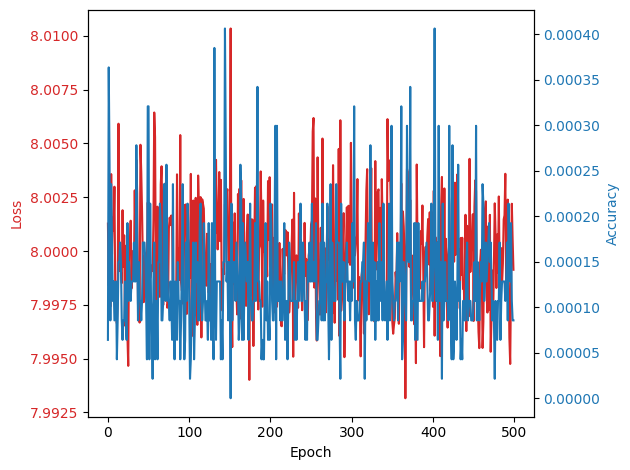

In [32]:
train(num_epochs = 500)

In [33]:
import torch

def generate_code(model, text, preprocessor, max_length=100):
    model.eval()
    text_tokenized = preprocessor.functionToTokenize([text])[0]
    text_numericalized = preprocessor.functionToVocab([text_tokenized])[0]
    text_tensor = torch.tensor(text_numericalized).unsqueeze(0)
    text_tensor = text_tensor.to(next(model.parameters()).device)

    with torch.no_grad():
        output = model(text_tensor)

    _, predicted_indices = torch.max(output, 2)
    predicted_code = [preprocessor.code_vocab.itos[idx.item()] for idx in predicted_indices[0]]
    generated_code = ' '.join(predicted_code[:min(max_length, len(predicted_code))])

    return generated_code

generated_code = generate_code(model, "Write a function to add two numbers.", preprocessor)
print(generated_code)


TypeError: Preprocessor.functionToTokenize() takes 1 positional argument but 2 were given